# ***Who Grade Binary Classification***

This notebook shows the process of classifying samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from typing import Tuple
from tqdm import tqdm
from pathlib import Path
from pyimzml.ImzMLParser import ImzMLParser
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import metrics as k_metrics
from tensorflow.keras import backend as K
from sklearn import metrics as s_metrics
from sklearn.model_selection import train_test_split

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_PATH = "./DHG/"
# Define folder that contains the preprocessed dataset
LEVEL_2_PATH = f"{DHG_PATH}/level_2"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"./models/binary_who_grade_classification"
# Define path to save plots
FIGURES_PATH = "./figures/binary_who_grade_classification"
# Define spectra dimension
SPECTRA_DIM = 24000
# Define number of epochs
EPOCHS = 100
# Define batch size
BATCH_SIZE = 256
# Define learning rate
LEARNING_RATE = 1e-3

### ***Creating output folders***

Next, let's create the output folders:

In [4]:
# Create output folder if doesn't exist
Path(FIGURES_PATH).mkdir(parents=True, exist_ok=True)
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [5]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)

# Define classification label
metadata_df["label"] = (metadata_df["who_grade"] > 2).astype(int)

# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all images:

In [6]:
# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Threshold image
    thresh_img = np.load(
        os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.npy")
    )

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, row.label, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "label", "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [7]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(LEVEL_2_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [8]:
def map_record(file_name: tf.Tensor, idx: tf.Tensor,
               label: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.

  Returns:
      Tuple[np.ndarray, int]: Input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label = (file_name.numpy(), idx.numpy(), label.numpy())

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  mzs, spectra = parsers[file_name].getspectrum(idx)

  # Return spectra and label
  return (spectra[((mzs >= 600) & (mzs <= 900))], label)


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): Input (spectra)
      y (tf.Tensor): Output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: Input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): File names of the dataset.
      indexes (np.ndarray): Indexes of the dataset.
      labels (np.ndarray): Labels of the dataset.
      batch_size (int): Batch size.
      shuffle (bool): Flag to indicate if to shuffle or not.

  Returns:
      tf.data.Dataset: Dataset
  """
  # Create dataset
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(file_names), seed=SEED)
  # Map record to model input
  ds = ds.map(
      lambda i, j, k: tf.
      py_function(func=map_record, inp=[i, j, k], Tout=[tf.float32, tf.int32])
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [9]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: Classification model.
  
  """
  return tf.keras.Sequential(
      [
          layers.InputLayer(input_shape=(SPECTRA_DIM,)),
          layers.Dense(1024),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(1024),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(512),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(1, activation='sigmoid')
      ]
  )

### ***Section classification:***
Next, let's apply classification on section samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [10]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in s_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Filter training data
  s_spectras_info_train = s_spectras_info.loc[train_filter]

  # Get x and y data for training
  X = s_spectras_info_train[["file_name", "idx"]].to_numpy()
  y = s_spectras_info_train["label"].to_numpy()

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Shuffle training labels
  np.random.shuffle(y_train)

  # Create data generators
  train_generator = create_ds(
      X_train[:, 0], X_train[:, 1].astype("int"), y_train, BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val[:, 0], X_val[:, 1].astype("int"), y_val, BATCH_SIZE, True
  )

  # Calculate class weights to make sure no imbalance data affect
  neg, pos = np.bincount(y_train.astype(int))
  weight_for_0 = (1 / neg) * ((neg + pos) / 2.0)
  weight_for_1 = (1 / pos) * ((neg + pos) / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_auc",
      mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  classification_model.compile(
      optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
      loss=losses.BinaryCrossentropy(label_smoothing=0.1), metrics=[
          k_metrics.TruePositives(name='tp'),
          k_metrics.FalsePositives(name='fp'),
          k_metrics.TrueNegatives(name='tn'),
          k_metrics.FalseNegatives(name='fn'),
          k_metrics.BinaryAccuracy(name='accuracy'),
          k_metrics.Precision(name='precision'),
          k_metrics.Recall(name='recall'),
          k_metrics.AUC(name='auc'),
          k_metrics.AUC(name='prc', curve='PR')
      ]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback,
                 model_es_callback], class_weight=class_weight
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

Epoch 1/100
96/96 [==============================] - 35s 336ms/step - loss: 0.8394 - tp: 7912.0000 - fp: 4154.0000 - tn: 4403.0000 - fn: 8071.0000 - accuracy: 0.5018 - precision: 0.6557 - recall: 0.4950 - auc: 0.5073 - prc: 0.6560 - val_loss: 1.2066 - val_tp: 1319.0000 - val_fp: 1045.0000 - val_tn: 1095.0000 - val_fn: 2677.0000 - val_accuracy: 0.3934 - val_precision: 0.5580 - val_recall: 0.3301 - val_auc: 0.3449 - val_prc: 0.5982
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\section_excluded_HG 1-s\assets
Epoch 2/100
96/96 [==============================] - 21s 213ms/step - loss: 0.7254 - tp: 9025.0000 - fp: 3771.0000 - tn: 4786.0000 - fn: 6958.0000 - accuracy: 0.5628 - precision: 0.7053 - recall: 0.5647 - auc: 0.5831 - prc: 0.7097 - val_loss: 0.7761 - val_tp: 1929.0000 - val_fp: 1278.0000 - val_tn: 862.0000 - val_fn: 2067.0000 - val_accuracy: 0.4549 - val_precision: 0.6015 - val_recall: 0.4827 - val_auc: 0.4364 - val_prc: 0.6368
INFO:tensorflow:Assets wri

In [11]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/section_train_metrics.csv")
# Print
train_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-s,0.352422,15377.0,1088.0,7469.0,606.0,0.930970,0.933920,0.962085,0.980622,0.989138
HG 11-11-12-s,0.262008,11096.0,438.0,9514.0,18.0,0.978354,0.962025,0.998380,0.999438,0.999503
HG 14-13-s,0.628306,8004.0,337.0,9615.0,5458.0,0.752499,0.959597,0.594562,0.892857,0.930927
HG 16-15-s,0.376871,14289.0,1568.0,7354.0,714.0,0.904619,0.901116,0.952410,0.957022,0.970657
HG 19-18-s,0.738405,9590.0,4444.0,3929.0,6393.0,0.555058,0.683340,0.600013,0.540533,0.680443
HG 29-25-23-21-20-s,0.450146,11884.0,265.0,4342.0,3017.0,0.831761,0.978188,0.797530,0.952170,0.984995
HG 6-7-s,0.736109,6010.0,3608.0,6344.0,8816.0,0.498587,0.624870,0.405369,0.543242,0.641244
HG 8-12-5-4-3-2-s,0.231168,9217.0,208.0,9139.0,0.0,0.988796,0.977931,1.000000,0.999985,0.999985
HG 9-10-s,0.815275,6217.0,2187.0,7765.0,8405.0,0.568975,0.739767,0.425181,0.655162,0.765747


In [12]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/section_validation_metrics.csv")
# Print
validation_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-s,0.814061,3032.0,1547.0,593.0,964.0,0.590776,0.662153,0.758759,0.540814,0.688965
HG 11-11-12-s,0.909993,2017.0,1473.0,1015.0,762.0,0.575660,0.577937,0.725801,0.607646,0.631573
HG 14-13-s,1.114438,1437.0,685.0,1803.0,1929.0,0.553468,0.677191,0.426916,0.554691,0.655612
HG 16-15-s,0.791488,2616.0,1403.0,828.0,1135.0,0.575727,0.650908,0.697414,0.574263,0.695694
HG 19-18-s,0.644448,2560.0,998.0,1096.0,1436.0,0.600328,0.719505,0.640641,0.632361,0.767754
HG 29-25-23-21-20-s,0.625652,2803.0,391.0,761.0,922.0,0.730777,0.877583,0.752483,0.743722,0.880463
HG 6-7-s,0.694460,1668.0,775.0,1713.0,2039.0,0.545763,0.682767,0.449960,0.622227,0.702886
HG 8-12-5-4-3-2-s,0.942477,1415.0,1115.0,1222.0,890.0,0.568074,0.559289,0.613883,0.595658,0.576178
HG 9-10-s,0.800519,1702.0,471.0,2017.0,1954.0,0.605306,0.783249,0.465536,0.642850,0.738136


#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [13]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]


Next, let's get some statistics about each left out section sample predictions:

In [14]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_section_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.0010906279,0.9962995648,0.7328961492,0.6609483361,0.2660815716,1,1
HG 11_2-s,0.0038003579,0.9988075495,0.7661342025,0.6832786202,0.2619329691,1,1
HG 12-s,0.0051778485,0.9992914200,0.8286594152,0.7083315253,0.2752924263,1,1
HG 14-s,0.0076836436,0.9884317517,0.1456610560,0.2050014585,0.1814579517,1,0
HG 13-s,0.0032586763,0.9872738123,0.1119645908,0.1875574142,0.2046894282,1,0
HG 15-s,0.0037672725,0.9971708655,0.6664180756,0.6162768006,0.2685086429,1,1
HG 16-s,0.0020250943,0.9945210218,0.4990883470,0.5067606568,0.2623499930,0,1
HG 19-s,0.3620864451,0.7313503623,0.6611552238,0.6154224277,0.0975754261,0,1
HG 18-s,0.3902681470,0.7424445748,0.6655902267,0.6423479319,0.0679500923,0,1


Next, let's evaluate the classification performance image-wise:

In [15]:
# Get accuracy
accuracy = s_metrics.accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get precision
precision = s_metrics.precision_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get recall
recall = s_metrics.recall_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get  f1 score
f1 = s_metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.240
Balanced  Accuracy: 0.188
Precision: 0.400
Recall: 0.375
F1 score: 0.387



Next, let's plot the roc curve image-wise:

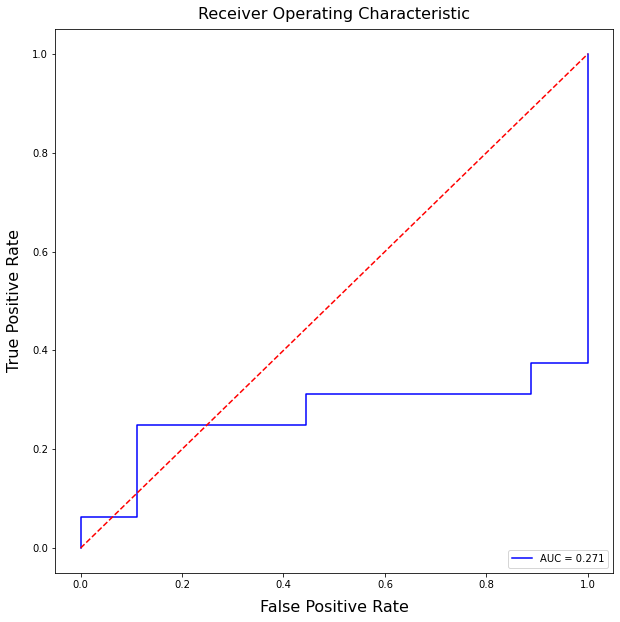

In [16]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

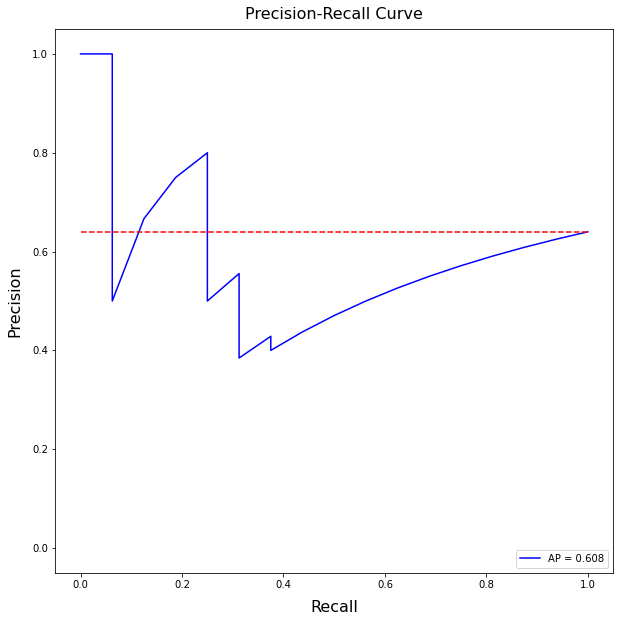

In [17]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [18]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = s_metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = s_metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = s_metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = s_metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.406
Balanced  Accuracy: 0.388
Precision: 0.480
Recall: 0.520
F1 score: 0.499



Next, let's plot the roc curve spectra-wise:

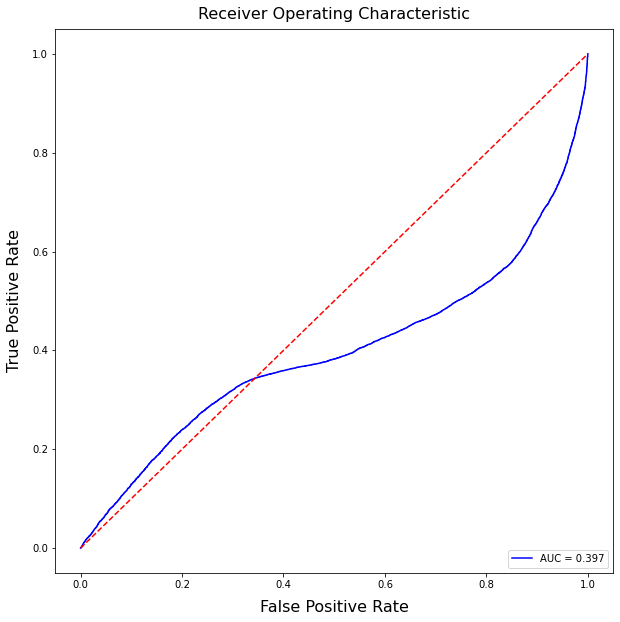

In [19]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

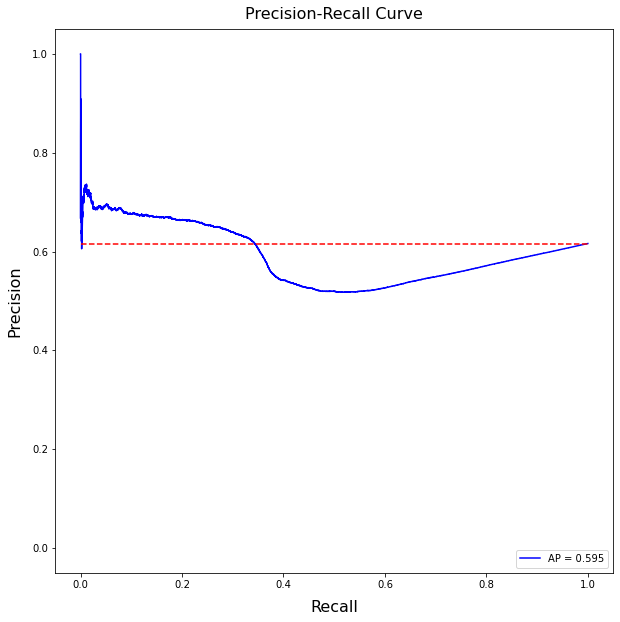

In [20]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

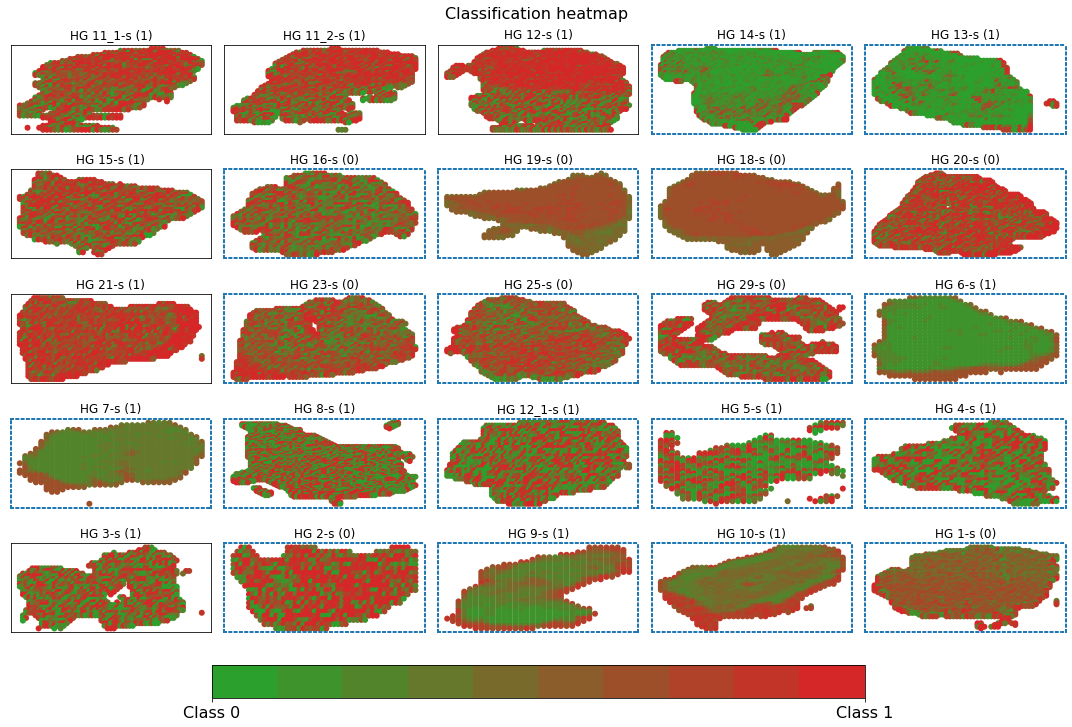

In [21]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

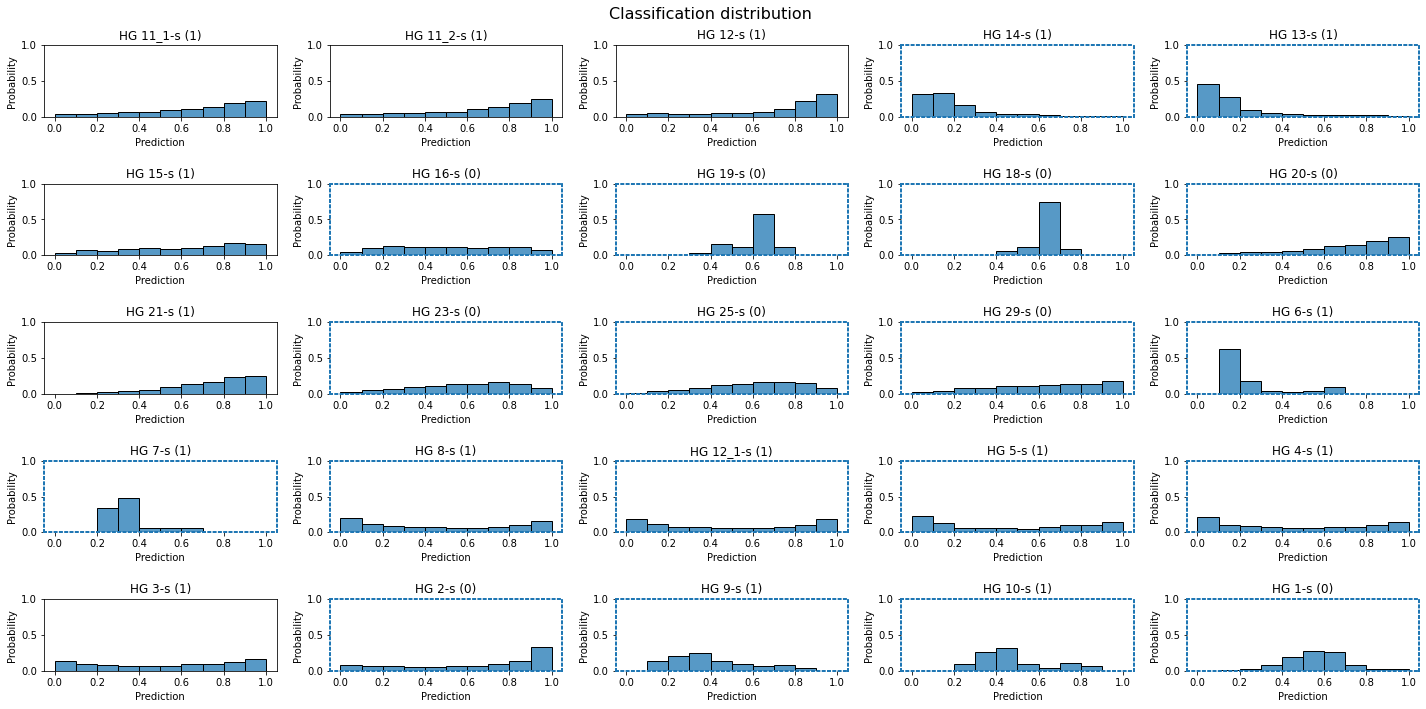

In [22]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0, 1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_distribution.png"),
    transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [23]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[(s_spectras_info.file_name == key) &
                                        s_spectras_info.is_tissue].x_coordinate,
                        1
                    ),
                    np.expand_dims(
                        s_spectras_info[(s_spectras_info.file_name == key) &
                                        s_spectras_info.is_tissue].y_coordinate,
                        1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***Replica classification:***
Next, let's apply classification on replica samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [24]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in r_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = r_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)

  # Filter training data
  r_spectras_info_train = r_spectras_info.loc[train_filter]

  # Get x and y data for training
  X = r_spectras_info_train[["file_name", "idx"]].to_numpy()
  y = r_spectras_info_train["label"].to_numpy()

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Shuffle training labels
  np.random.shuffle(y_train)

  # Create data generators
  train_generator = create_ds(
      X_train[:, 0], X_train[:, 1].astype("int"), y_train, BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val[:, 0], X_val[:, 1].astype("int"), y_val, BATCH_SIZE, True
  )

  # Calculate class weights to make sure no imbalance data affect
  neg, pos = np.bincount(y_train.astype(int))
  weight_for_0 = (1 / neg) * ((neg + pos) / 2.0)
  weight_for_1 = (1 / pos) * ((neg + pos) / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"replica_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_auc",
      mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  classification_model.compile(
      optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
      loss=losses.BinaryCrossentropy(label_smoothing=0.1), metrics=[
          k_metrics.TruePositives(name='tp'),
          k_metrics.FalsePositives(name='fp'),
          k_metrics.TrueNegatives(name='tn'),
          k_metrics.FalseNegatives(name='fn'),
          k_metrics.BinaryAccuracy(name='accuracy'),
          k_metrics.Precision(name='precision'),
          k_metrics.Recall(name='recall'),
          k_metrics.AUC(name='auc'),
          k_metrics.AUC(name='prc', curve='PR')
      ]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback,
                 model_es_callback], class_weight=class_weight
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

Epoch 1/100
142/142 [==============================] - 68s 465ms/step - loss: 0.8150 - tp: 10345.0000 - fp: 7697.0000 - tn: 7775.0000 - fn: 10316.0000 - accuracy: 0.5015 - precision: 0.5734 - recall: 0.5007 - auc: 0.5016 - prc: 0.5701 - val_loss: 0.7106 - val_tp: 3156.0000 - val_fp: 1816.0000 - val_tn: 2052.0000 - val_fn: 2010.0000 - val_accuracy: 0.5765 - val_precision: 0.6348 - val_recall: 0.6109 - val_auc: 0.5874 - val_prc: 0.6663
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\replica_excluded_HG 1-r\assets
Epoch 2/100
142/142 [==============================] - 42s 298ms/step - loss: 0.7168 - tp: 11640.0000 - fp: 6960.0000 - tn: 8512.0000 - fn: 9021.0000 - accuracy: 0.5577 - precision: 0.6258 - recall: 0.5634 - auc: 0.5812 - prc: 0.6389 - val_loss: 0.6997 - val_tp: 2607.0000 - val_fp: 2013.0000 - val_tn: 1855.0000 - val_fn: 2559.0000 - val_accuracy: 0.4939 - val_precision: 0.5643 - val_recall: 0.5046 - val_auc: 0.5176 - val_prc: 0.6142
Epoch 3/100
142/14

In [25]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/replica_train_metrics.csv")
# Print
train_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-r,0.7006065249,12202.0000000000,7417.0000000000,8055.0000000000,8459.0000000000,0.5606232285,0.6219481230,0.5905812979,0.5834922194,0.6566647887
HG 12-11-r,0.2609963715,18035.0000000000,307.0000000000,17209.0000000000,757.0000000000,0.9706951380,0.9832624793,0.9597169161,0.9970920086,0.9973828793
HG 14-13-r,0.5137483478,14057.0000000000,4966.0000000000,12550.0000000000,2500.0000000000,0.7808822393,0.7389475703,0.8490064740,0.8807846308,0.8916179538
HG 16-15-r,0.5633792877,17484.0000000000,7606.0000000000,8566.0000000000,1947.0000000000,0.7316799164,0.6968513131,0.8997992873,0.8259728551,0.8272225857
HG 18-19-18-r,0.6120260358,10907.0000000000,1523.0000000000,9989.0000000000,9754.0000000000,0.6494886875,0.8774738312,0.5279028416,0.8068870902,0.8781426549
HG 29-25-23-21-20-r,0.5807664394,16631.0000000000,5462.0000000000,6073.0000000000,2536.0000000000,0.7394958138,0.7527723908,0.8676892519,0.7867966890,0.8464011550
HG 6-6-7-r,0.4964880347,13019.0000000000,1540.0000000000,15976.0000000000,5145.0000000000,0.8126401305,0.8942235112,0.7167474031,0.9151926041,0.9223604202
HG 8-5-4-3-2-r,0.2107033283,14402.0000000000,26.0000000000,15350.0000000000,2.0000000000,0.9990597963,0.9981979728,0.9998611212,0.9999992847,0.9999992847
HG 9-10-r,0.4985481203,16309.0000000000,5706.0000000000,11811.0000000000,1145.0000000000,0.8040948510,0.7408130765,0.9343990088,0.9235131741,0.9273447394


In [26]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/replica_validation_metrics.csv")
# Print
validation_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-r,0.7105590701,3156.0000000000,1816.0000000000,2052.0000000000,2010.0000000000,0.5764887929,0.6347545981,0.6109175086,0.5873896480,0.6662600040
HG 12-11-r,1.0214691162,2858.0000000000,1816.0000000000,2564.0000000000,1840.0000000000,0.5972681046,0.6114677191,0.6083439589,0.6085163355,0.6105096340
HG 14-13-r,0.7413319945,2664.0000000000,2498.0000000000,1882.0000000000,1475.0000000000,0.5336307287,0.5160790682,0.6436337233,0.5894999504,0.5861056447
HG 16-15-r,0.7430741787,3765.0000000000,2608.0000000000,1435.0000000000,1093.0000000000,0.5842040181,0.5907735825,0.7750102878,0.6146871448,0.6744987965
HG 18-19-18-r,0.6711440682,2408.0000000000,644.0000000000,2234.0000000000,2758.0000000000,0.5770760775,0.7889908552,0.4661246538,0.6804000735,0.7771577835
HG 29-25-23-21-20-r,0.6928548813,3541.0000000000,1912.0000000000,972.0000000000,1251.0000000000,0.5879364014,0.6493673325,0.7389398813,0.5819299221,0.7282806635
HG 6-6-7-r,0.7426007390,1946.0000000000,1426.0000000000,2954.0000000000,2595.0000000000,0.5492658019,0.5771055818,0.4285399616,0.5696673989,0.5777947307
HG 8-5-4-3-2-r,1.1885206699,2026.0000000000,2067.0000000000,1777.0000000000,1575.0000000000,0.5108126402,0.4949914515,0.5626214743,0.5212138891,0.5099502206
HG 9-10-r,0.7270349860,3226.0000000000,2784.0000000000,1595.0000000000,1138.0000000000,0.5514125824,0.5367720723,0.7392300367,0.6057525873,0.6151898503


#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [27]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:39<00:00,  3.99s/it]


Next, let's get some statistics about each left out section sample predictions:

In [28]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frame of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.0216827020,0.9881194234,0.6826842427,0.6368486881,0.2442359477,1,1
HG 11-r,0.0001908399,0.9998804331,0.7609702349,0.6251572967,0.3638742268,1,1
HG 14-r,0.1065666527,0.9530218840,0.5268852115,0.5345154405,0.1448618770,1,1
HG 13-r,0.0074417517,0.9858646393,0.5096367598,0.5205695629,0.1135540083,1,1
HG 16-r,0.1112965867,0.8799621463,0.6098936200,0.5968070030,0.1096578464,0,1
HG 15-r,0.0006821173,0.9976346493,0.4626985788,0.4624970257,0.1964467615,1,0
HG 18_1-r,0.1066649631,0.9392351508,0.5763480067,0.5743592381,0.1139735579,0,1
HG 19-r,0.0369083993,0.9903197289,0.6662962437,0.6617715955,0.1035756096,0,1
HG 18_2-r,0.0187510699,0.9817657471,0.5840752721,0.5887448788,0.0789199695,0,1


Next, let's evaluate the classification performance image-wise:

In [29]:
# Get accuracy
accuracy = s_metrics.accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get precision
precision = s_metrics.precision_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get recall
recall = s_metrics.recall_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get  f1 score
f1 = s_metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_replica_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.440
Balanced  Accuracy: 0.400
Precision: 0.529
Recall: 0.600
F1 score: 0.562



Next, let's plot the roc curve image-wise:

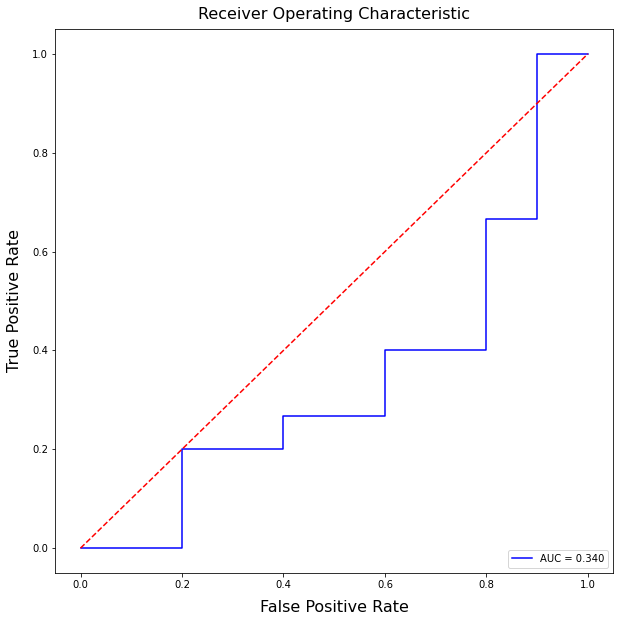

In [30]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

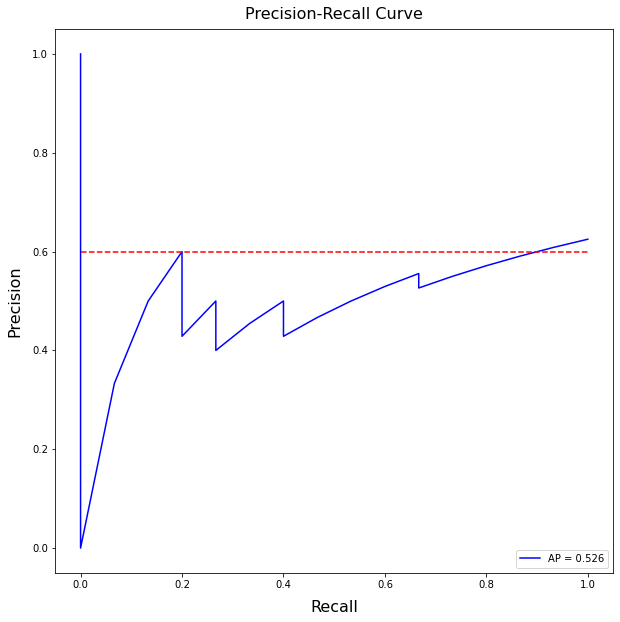

In [31]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [32]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = s_metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = s_metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = s_metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = s_metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_replica_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.423
Balanced  Accuracy: 0.409
Precision: 0.534
Recall: 0.471
F1 score: 0.500



Next, let's plot the roc curve spectra-wise:

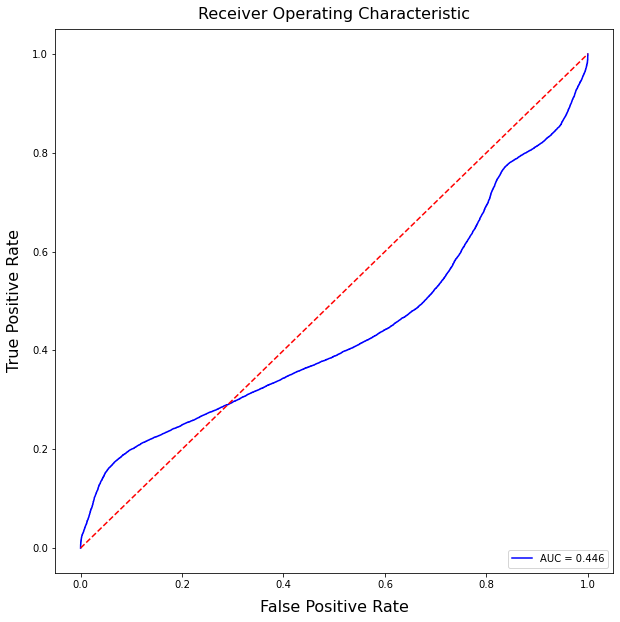

In [33]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

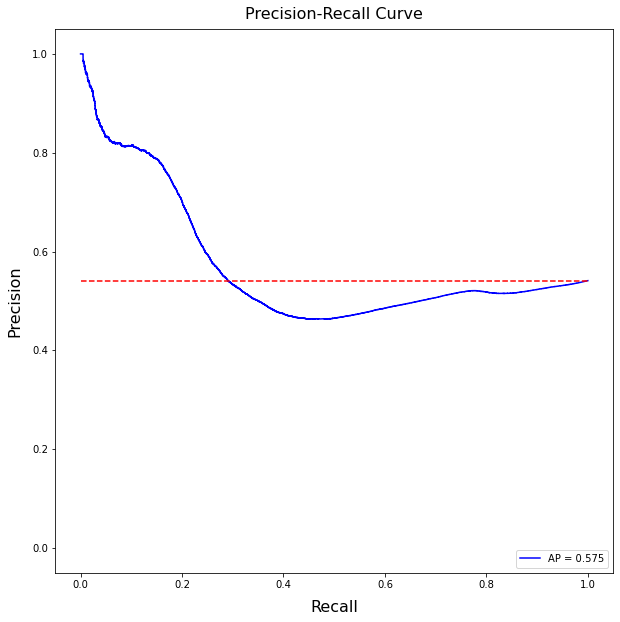

In [34]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

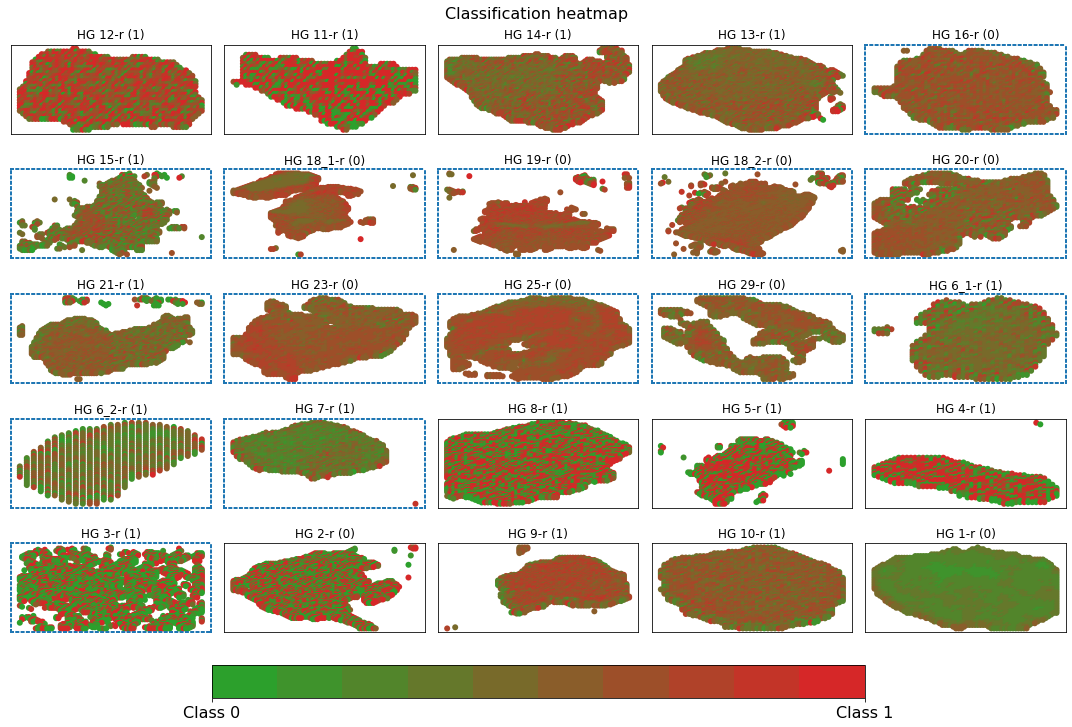

In [35]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

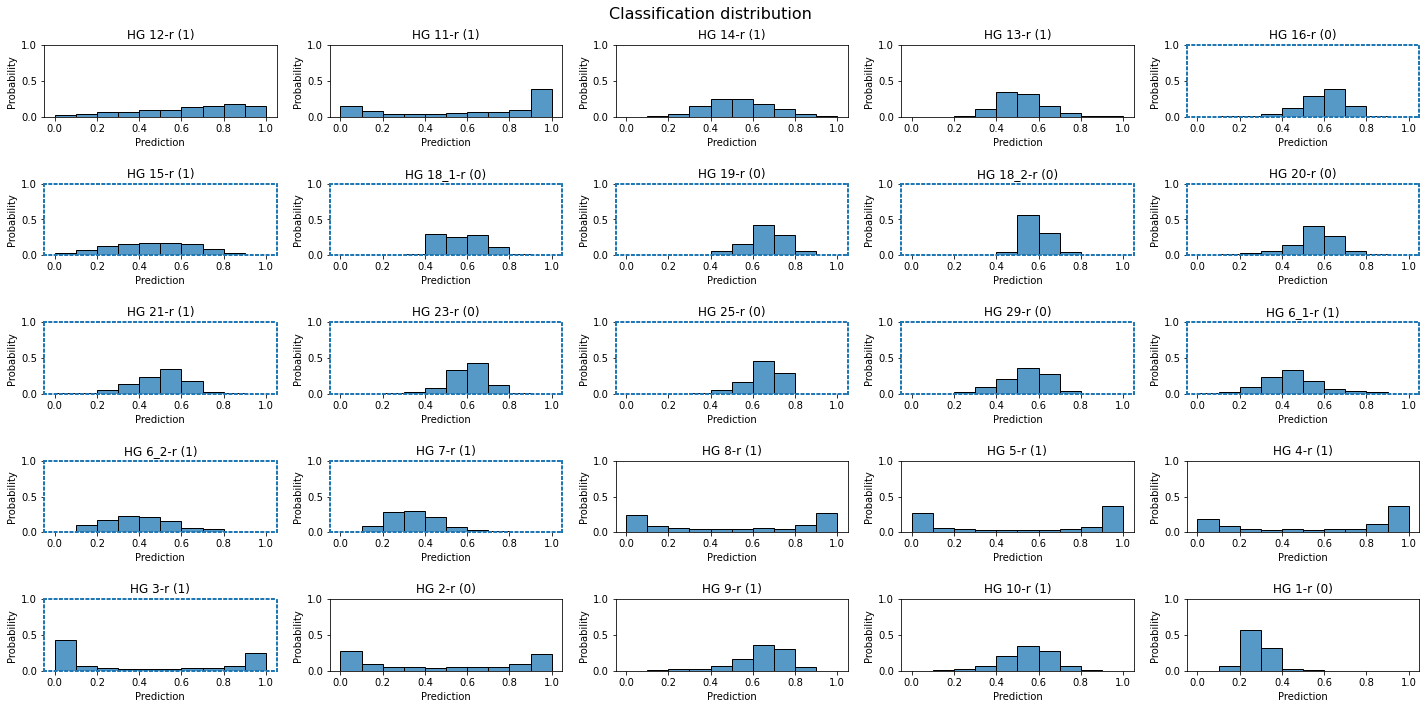

In [36]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0, 1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_distribution.png"),
    transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [37]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[(r_spectras_info.file_name == key) &
                                        r_spectras_info.is_tissue].x_coordinate,
                        1
                    ),
                    np.expand_dims(
                        r_spectras_info[(r_spectras_info.file_name == key) &
                                        r_spectras_info.is_tissue].y_coordinate,
                        1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [38]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()